# Project 3 - FYS5555
## Analyzis of data from ATLAS

### Introduction
In this project I have studied the use of machine learning methods in analyzing ATLAS data. I have mainly looked at boosted decision trees (BDT) and through this notebook you can see all of my steps. 

The first step in every code is to import all the packages you need to run the code. If you don't have the packages on your computer, you can read the README file at github. There you can also find a directory with all of the figures from the results.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

In [2]:
data = pd.read_csv('data/training_10k.csv') # Change this to the ATLAS open data

In [3]:
print('Size of data: {}'.format(data.shape))
print('Number of events: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))

print ('\nList of features in dataset:')
for col in data.columns:
    print(col)

Size of data: (10000, 33)
Number of events: 10000
Number of columns: 33

List of features in dataset:
EventId
DER_mass_MMC
DER_mass_transverse_met_lep
DER_mass_vis
DER_pt_h
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_deltar_tau_lep
DER_pt_tot
DER_sum_pt
DER_pt_ratio_lep_tau
DER_met_phi_centrality
DER_lep_eta_centrality
PRI_tau_pt
PRI_tau_eta
PRI_tau_phi
PRI_lep_pt
PRI_lep_eta
PRI_lep_phi
PRI_met
PRI_met_phi
PRI_met_sumet
PRI_jet_num
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi
PRI_jet_all_pt
Weight
Label


In [4]:
# look at column labels --- notice last one is "Label" and first is "EventId" also "Weight"
print('Number of signal events: {}'.format(len(data[data.Label == 's'])))
print('Number of background events: {}'.format(len(data[data.Label == 'b'])))
print('Fraction signal: {}'.format(len(data[data.Label == 's'])/(float)(len(data[data.Label == 's']) + len(data[data.Label == 'b']))))

Number of signal events: 3372
Number of background events: 6628
Fraction signal: 0.3372


In [5]:
data['Label'] = data.Label.astype('category')

In [6]:
data_train = data[:8000]
data_test = data[8000:]

In [7]:
print('Number of training samples: {}'.format(len(data_train)))
print('Number of testing samples: {}'.format(len(data_test)))

print('\nNumber of signal events in training set: {}'.format(len(data_train[data_train.Label == 's'])))
print('Number of background events in training set: {}'.format(len(data_train[data_train.Label == 'b'])))
print('Fraction signal: {}'.format(len(data_train[data_train.Label == 's'])/(float)(len(data_train[data_train.Label == 's']) + len(data_train[data_train.Label == 'b']))))

Number of training samples: 8000
Number of testing samples: 2000

Number of signal events in training set: 2688
Number of background events in training set: 5312
Fraction signal: 0.336


In [8]:
feature_names = data.columns[1:-2]  # we skip the first and last two columns because they are the ID, weight, and label
train = xgb.DMatrix(data=data_train[feature_names],label=data_train.Label.cat.codes,
                    missing=-999.0,feature_names=feature_names)
test = xgb.DMatrix(data=data_test[feature_names],label=data_test.Label.cat.codes,
                   missing=-999.0,feature_names=feature_names)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [9]:
print('Number of training samples: {}'.format(train.num_row()))
print('Number of testing samples: {}'.format(test.num_row()))

print('\nNumber of signal events in training set: {}'.format(len(np.where(train.get_label())[0])))

Number of training samples: 8000
Number of testing samples: 2000

Number of signal events in training set: 2688


In [10]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [11]:
booster = xgb.train(param,train,num_boost_round=num_trees)

In [12]:
print(booster.eval(test))

[0]	eval-error:0.172500	eval-logloss:0.382643	eval-rmse:0.346852


In [13]:
predictions = booster.predict(test)

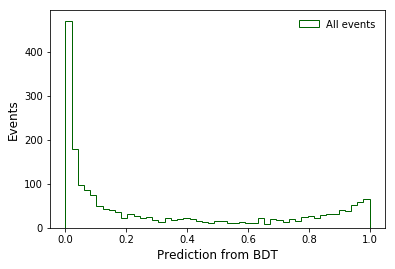

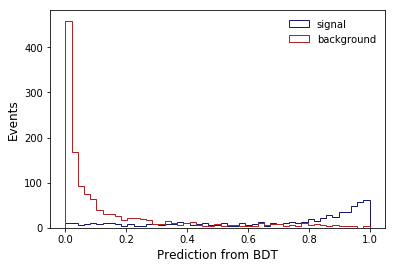

In [14]:
# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal');
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
No handles with labels found to put in legend.


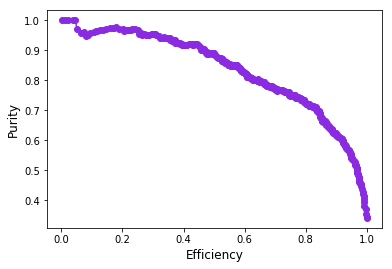

In [15]:
# choose score cuts:
cuts = np.linspace(0,1,500);
nsignal = np.zeros(len(cuts));
nbackground = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal[i] = len(np.where(predictions[test.get_label().astype(bool)] > cut)[0]);
    nbackground[i] = len(np.where(predictions[~(test.get_label().astype(bool))] > cut)[0]);
    
# plot efficiency vs. purity (ROC curve)
plt.figure();
plt.plot(nsignal/len(data_test[data_test.Label == 's']),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.legend(frameon=False);

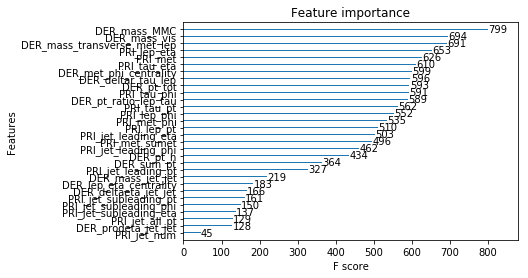

In [16]:
xgb.plot_importance(booster,grid=False);

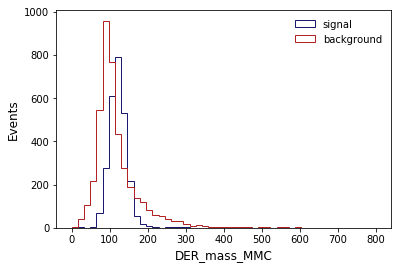

In [17]:
plt.figure();
plt.hist(data_train.DER_mass_MMC[data_train.Label == 's'],bins=np.linspace(0,800,50),
         histtype='step',color='midnightblue',label='signal');
plt.hist(data_train.DER_mass_MMC[data_train.Label == 'b'],bins=np.linspace(0,800,50),
         histtype='step',color='firebrick',label='background');

plt.xlabel('DER_mass_MMC',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

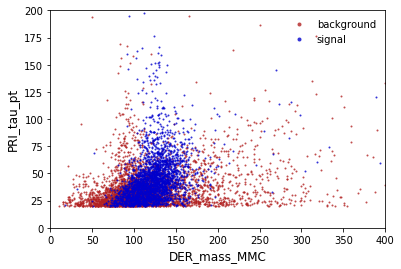

In [18]:
plt.figure();
plt.plot(data_train.DER_mass_MMC[data_train.Label == 'b'],data_train.PRI_tau_pt[data_train.Label == 'b'],
         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.8,label='background');
plt.plot(data_train.DER_mass_MMC[data_train.Label == 's'],data_train.PRI_tau_pt[data_train.Label == 's'],
         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.8,label='signal');

plt.xlim(0,400);
plt.ylim(0,200);
plt.xlabel('DER_mass_MMC',fontsize=12);
plt.ylabel('PRI_tau_pt',fontsize=12);
plt.legend(frameon=False,numpoints=1,markerscale=2);